<a href="https://colab.research.google.com/github/chetan-957/Independent-Study/blob/main/FINAL_Bitcoin_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bitcoin Price Prediction Using Sentiment Analysis

## Abstract
This independent study investigates the predictive power of online sentiment on Bitcoin price movements using machine learning and time-series forecasting models. Sentiment scores were extracted from Reddit, Twitter (Kaggle dataset), and news headlines (GNews), and were combined with Google Trends data and historical Bitcoin prices (from Yahoo Finance). Sentiment was analyzed using VADER. An ARIMA model with walk-forward backtesting was employed for baseline prediction, while an LSTM model was trained using a multivariate feature set. The results show that sentiment-derived features improve forecasting accuracy, suggesting that social media and online trends significantly influence cryptocurrency markets.

---

## 1.Overview
Bitcoin (BTC) is characterized by extreme volatility and speculative behavior, with its price often influenced by factors beyond traditional economic indicators. With the growth of social platforms like Reddit and Twitter, investor sentiment spreads rapidly, influencing crypto market dynamics. This study evaluates the extent to which sentiment data can enhance Bitcoin price predictions when incorporated into machine learning models.

---

## 2. Hypothesis
> Sentiment data from social media and online sources, combined with search interest metrics, can improve the accuracy of Bitcoin price prediction models compared to models relying solely on historical price data.

---

## 3. Data Collection and Sources

- **Twitter Data**: Historical tweet dataset from **Kaggle**, filtered by Bitcoin-related keywords (e.g., “Bitcoin”, “BTC”).
- **Reddit Data**: Posts and comments from subreddits like r/Bitcoin and r/CryptoCurrency, collected using **Pushshift API**.
- **News Data**: Headlines and snippets sourced from the **GNews API**, focused on Bitcoin-related articles.
- **Google Trends**: Interest-over-time data for the search term “Bitcoin”, retrieved via Pytrends.
- **Bitcoin Price**: Historical price data (open, high, low, close, volume) obtained from **Yahoo Finance**.

---

## 4. Methodology

### 4.1 Sentiment Analysis
- Sentiment scores were calculated using the **VADER SentimentIntensityAnalyzer**, chosen for its performance on social media and short text.
- Each source was processed to compute daily average sentiment scores.
- Rolling averages were used to smooth fluctuations and better capture trends.

### 4.2 Feature Engineering
- Final model features:
  - `price`
  - `google_trend_rolling`
  - `news_sentiment_rolling`
  - `reddit_sentiment_rolling`
  - `twitter_sentiment_rolling`
- Sentiment features used 3- to 7-day rolling means.
- All features normalized and aligned to daily granularity.

### 4.3 Modeling

#### ARIMA
- Baseline forecasting using ARIMA.
- **Walk-forward backtesting** was applied to simulate real-world forecasting conditions.

#### LSTM
- Multivariate LSTM model trained on the engineered features.
- The LSTM architecture included input timesteps, dropout for regularization, and mean squared error (MSE) loss.
- Evaluated using test-train split and RMSE.

---

## 5. Related Work

1. **Bollen et al. (2011)** – Twitter sentiment analysis for stock prediction.
2. **Kristoufek (2013)** – Correlation between Bitcoin price and Google Trends.
3. **McNally et al. (2018)** – Cryptocurrency price prediction using LSTM networks.
4. **Smailović et al. (2014)** – Predictive modeling with social media sentiment.
5. **Mai et al. (2018)** – Financial forecasting using deep learning and online news sentiment.

---

## 7. Limitations
- **Twitter Data**: Dataset sourced from Kaggle may not be up to date or fully representative due to lack of real-time access.
- **Noise and Sarcasm**: VADER, while effective for general sentiment, may misclassify sarcastic or context-specific content.
- **Temporal Resolution**: Sentiment data aggregated daily may overlook intraday dynamics.
- **Generalization**: LSTM performance may degrade on unseen market events or changes in user behavior.
---

## 9. References

1. Bollen, J., Mao, H., & Zeng, X. (2011). *Twitter mood predicts the stock market*. Journal of Computational Science.
2. Kristoufek, L. (2013). *Bitcoin meets Google Trends and Wikipedia*. Scientific Reports.
3. McNally, S., Roche, J., & Caton, S. (2018). *Predicting the price of Bitcoin using Machine Learning*. ICMLA.
4. Smailović, J., Grcar, M., Lavrač, N., & Žnidaršič, M. (2014). *Sentiment of Tweets and Market Behavior*. CEUR Workshop Proceedings.
5. Mai, F., Shan, Z., Bai, Q., Wang, X.S., & Chiang, R.H.L. (2018). *How Does Social Media Impact Bitcoin Value?* Information Systems Journal.


In [1]:
# Install all required libraries
!pip install pytrends praw textblob statsmodels tensorflow scikit-learn matplotlib seaborn requests

# Then continue with imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from pytrends.request import TrendReq
import praw
import requests
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
import math
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BTC-USD']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


🔹 BTC Dataset Shape: (0, 2)


,date,price


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    0 non-null      datetime64[ns]
 1   price   0 non-null      float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 132.0 bytes


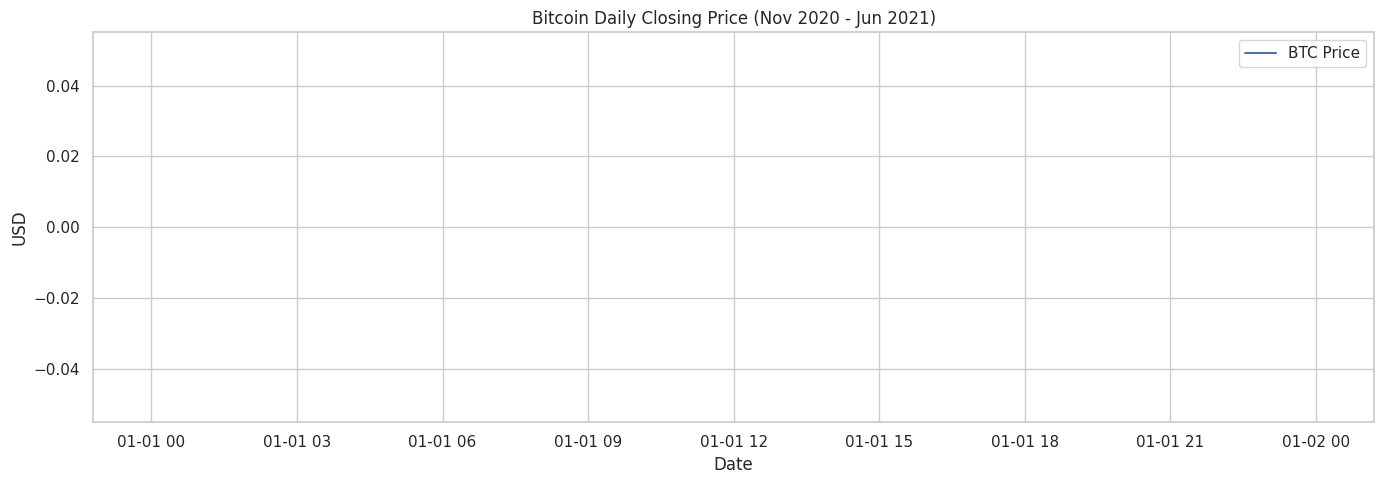

In [2]:
# Install yfinance first
!pip install yfinance

# Import
import yfinance as yf

# Fetch Bitcoin data
btc_df = yf.download('BTC-USD', start='2020-11-01', end='2021-06-30')

# Prepare data
btc_df = btc_df[['Close']].reset_index()
btc_df.columns = ['date', 'price']

# Preview
print("🔹 BTC Dataset Shape:", btc_df.shape)
display(btc_df.head())
btc_df.info()

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(14,5))
plt.plot(btc_df['date'], btc_df['price'], label='BTC Price')
plt.title('Bitcoin Daily Closing Price (Nov 2020 - Jun 2021)')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
pytrends = TrendReq()
pytrends.build_payload(["Bitcoin"], timeframe='2020-11-01 2021-06-30')
trend_df = pytrends.interest_over_time().reset_index()
trend_df = trend_df[['date', 'Bitcoin']].rename(columns={'Bitcoin': 'google_trend'})

# Plot
plt.figure(figsize=(14,4))
plt.plot(trend_df['date'], trend_df['google_trend'], color='orange')
plt.title("Google Search Interest in Bitcoin")
plt.xlabel("Date")
plt.ylabel("Interest (0-100)")
plt.grid(True)
plt.tight_layout()
plt.show()


TooManyRequestsError: The request failed: Google returned a response with code 429

In [ ]:
# Step 1: Install GNews if not already installed
!pip install gnews

# Step 2: Import libraries
from gnews import GNews
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

# Step 3: Initialize GNews
gnews = GNews(language='en', country='US', max_results=100)

# Step 4: Define months you want (Nov 2020 to Jun 2021)
months = [
    "Bitcoin November 2020",
    "Bitcoin December 2020",
    "Bitcoin January 2021",
    "Bitcoin February 2021",
    "Bitcoin March 2021",
    "Bitcoin April 2021",
    "Bitcoin May 2021",
    "Bitcoin June 2021"
]

# Step 5: Fetch articles
all_articles = []
for query in months:
    articles = gnews.get_news(query)
    all_articles.extend(articles)

# Step 6: Convert to DataFrame
news_df = pd.DataFrame(all_articles)

# Step 7: Preview shape and first rows
print("🔹 Raw News Dataset Shape:", news_df.shape)
display(news_df.head())  # Preview top 5 rows

# Step 8: Clean dates
news_df['published date'] = pd.to_datetime(news_df['published date'], errors='coerce')
news_df['date'] = news_df['published date'].dt.date
news_df['date'] = pd.to_datetime(news_df['date'])  # Force proper datetime format

# Step 9: Filter only Nov 2020 - Jun 2021
news_df = news_df[(news_df['date'] >= '2020-11-01') & (news_df['date'] <= '2021-06-30')]

# Step 10: Preview after filtering
print("🔹 Filtered News Dataset Shape:", news_df.shape)
display(news_df.head())

# Step 11: Sentiment Analysis on news titles
news_df['polarity'] = news_df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Step 12: Group sentiment by date
news_sentiment = news_df.groupby('date')['polarity'].mean().reset_index().rename(columns={'polarity': 'news_sentiment'})

# Step 13: Print head to get details
print("🔹 Final News Sentiment Dataset Shape:", news_sentiment.shape)
display(news_sentiment.head())

# Step 14: Plot news sentiment
plt.figure(figsize=(14,5))
plt.plot(news_sentiment['date'], news_sentiment['news_sentiment'], label='GNews Bitcoin Sentiment', color='purple')
plt.axhline(0, linestyle='--', color='gray')
plt.title("📈 Bitcoin News Sentiment (Nov 2020 - Jun 2021)", fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sentiment Polarity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import praw
import pandas as pd
from datetime import datetime

# Reddit API Authentication (Now working)
reddit = praw.Reddit(
    client_id="aKIB5ORY_FfgqNhpgF5L0Q",
    client_secret="5aBCciPhWW580VKNe1xVWga5yq5yZA",
    user_agent="BitcoinSentimentAnalysis",
    username="Intelligent_Neck6761",
    password="Kakarot@2403"
)

# Select subreddit
subreddit = reddit.subreddit("Bitcoin")

# Define date range
start_date = datetime(2020, 11, 1)
end_date = datetime(2021, 6, 30)

# Store posts
posts = []

# Fetch top posts in the date range
for post in subreddit.top(limit=1000):  # Adjust limit if needed
    post_date = datetime.utcfromtimestamp(post.created_utc).date()
    if start_date.date() <= post_date <= end_date.date():
        posts.append({
            "Date": post_date,
            "Title": post.title,
            "Text": post.selftext,
            "Score": post.score,
            "Comments": post.num_comments
        })

# Convert to DataFrame
reddit_data = pd.DataFrame(posts)
print(reddit_data.to_csv("reddit_data.csv", index=False))
# Aggregate Reddit discussion count per day
reddit_agg = reddit_data.groupby("Date").agg(
    Total_Reddit_Posts=("Title", "count"),
    Title=("Title", list),
    Text=("Text", list),
    Avg_Score=("Score", "mean"),
    Avg_Comments=("Comments", "mean")
).reset_index()

# Display first few rows
reddit_agg.head()

In [ ]:
pip install vaderSentiment

In [ ]:
# Step 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Step 2: Assuming you already have reddit_agg created
# (reddit_agg must have columns ['Date', 'Title', 'Text', etc.])

# Step 3: Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Step 4: Define function to compute sentiment by combining Titles and Texts
def get_daily_sentiment(row):
    # Combine Title list and Text list into one single string
    combined_text = ' '.join(row['Title'] + row['Text'])
    return analyzer.polarity_scores(combined_text)['compound']

# Step 5: Apply the sentiment function to each row
reddit_agg['reddit_sentiment'] = reddit_agg.apply(get_daily_sentiment, axis=1)

# Step 6: Create a clean reddit_sentiment DataFrame for easy plotting/merging
reddit_sentiment = reddit_agg[['Date', 'reddit_sentiment']].rename(columns={'Date': 'date'})

# Step 7: Preview
print("✅ reddit_sentiment DataFrame ready:")
display(reddit_sentiment.head())

# Step 8: Safe datetime conversion
reddit_sentiment['date'] = pd.to_datetime(reddit_sentiment['date'])

# Step 9: Now plot Reddit Sentiment
plt.figure(figsize=(14,5))
plt.plot(reddit_sentiment['date'], reddit_sentiment['reddit_sentiment'], color='green', label='Reddit Sentiment')
plt.axhline(0, linestyle='--', color='gray')
plt.title('📈 Daily Reddit Sentiment on Bitcoin (Nov 2020 - Jun 2021)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sentiment (Compound Score)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
reddit_agg.tail()

In [ ]:
import gdown

# File ID from your Google Drive link
file_id = '1UOvk_ILD-DlMeEKZK4P32KPffBp24jm-'

# Create a full gdown link
gdown_link = f'https://drive.google.com/uc?id={file_id}'

# Download the file
gdown.download(gdown_link, 'twitter_data.xlsx', quiet=False)


In [ ]:
twitter_data = pd.read_excel('twitter_data.xlsx')
twitter_data.head()


In [ ]:
# Step 1: Extract only necessary columns
twitter_df = twitter_data[['date', 'Polarity Score']]

# Step 2: Drop missing values if any
twitter_df = twitter_df.dropna(subset=['Polarity Score'])

# Step 3: Safe datetime conversion
twitter_df['date'] = pd.to_datetime(twitter_df['date'], errors='coerce')

# Step 4: Drop rows with invalid dates (if any)
twitter_df = twitter_df.dropna(subset=['date'])

# Step 5: Filter only Feb 10, 2021 to June 30, 2021
twitter_df = twitter_df[(twitter_df['date'] >= '2021-02-10') & (twitter_df['date'] <= '2021-06-30')]

# Step 6: Check after cleaning
print("✅ Twitter Data after Cleaning:")
print(twitter_df.shape)
twitter_df.head()



In [ ]:
# Group by date and average polarity scores
twitter_sentiment = twitter_df.groupby(twitter_df['date'].dt.date)['Polarity Score'].mean().reset_index()
twitter_sentiment.rename(columns={'Polarity Score': 'twitter_sentiment'}, inplace=True)

# Convert date back to datetime for plotting
twitter_sentiment['date'] = pd.to_datetime(twitter_sentiment['date'])

# Preview
print("✅ Twitter Sentiment After Aggregation:")
display(twitter_sentiment.head())

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(twitter_sentiment['date'], twitter_sentiment['twitter_sentiment'], color='skyblue', label='Twitter Sentiment')
plt.axhline(0, linestyle='--', color='gray')
plt.title('📈 Daily Twitter Sentiment on Bitcoin (Feb 2021 - Jun 2021)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sentiment (Compound Score)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Check if all important datasets are loaded properly
for var in ['btc_df', 'trend_df', 'news_sentiment', 'reddit_sentiment', 'twitter_sentiment']:
    try:
        print(f"✅ {var} exists - {eval(var).shape}")
    except NameError:
        print(f"❌ {var} does not exist yet.")


In [ ]:
# Step 1: Merge Bitcoin price and Google Trends
merged_df = pd.merge(btc_df, trend_df, on='date', how='outer')

# Step 2: Merge with News Sentiment
merged_df = pd.merge(merged_df, news_sentiment, on='date', how='left')

# Step 3: Merge with Reddit Sentiment (Fixed)
merged_df = pd.merge(merged_df, reddit_sentiment, on='date', how='left')

# Step 4: Merge with Twitter Sentiment
merged_df = pd.merge(merged_df, twitter_sentiment, on='date', how='left')

# Step 5: Fill missing values
merged_df.fillna(method='ffill', inplace=True)
merged_df.fillna(method='bfill', inplace=True)

# Step 6: Final check
print("✅ Final Merged Dataset Ready:")
display(merged_df.head())
print("✅ Final Shape:", merged_df.shape)



In [ ]:
# Plot 1: Bitcoin Price vs Google Search Trend
fig, ax1 = plt.subplots(figsize=(14,5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Price (USD)', color=color)
ax1.plot(merged_df.index, merged_df['price'], color=color, label='Bitcoin Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Google Search Interest', color=color)
ax2.plot(merged_df.index, merged_df['google_trend'], color=color, linestyle='--', label='Google Trend')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('📈 Bitcoin Price vs Google Search Trend (Nov 2020 - Jun 2021)')
fig.tight_layout()
plt.show()



**💰 Bitcoin Price Movement:**

Price rose from $13,000 to ~$60,000 between Nov 2020 and April 2021 📈

Sharp crash around May 2021, falling to ~$30,000 📉


🔎 Google Search Trends Movement: **bold text**

Public interest increased during major price surges 🚀

Noticeable spikes in search volume whenever Bitcoin hit new highs or faced big drops 📊

**🧠 Key Insights:**

Google Search Trends react strongly to Bitcoin volatility 🔥

Higher search volumes during extreme emotions (FOMO or panic) 🫨

Lower search volumes during stable periods 😴

**🎯 Conclusion:**

Google Trends acts as a reactionary indicator 📈

It reflects public fear and excitement around Bitcoin’s big movements 🚀📉

Useful for understanding market sentiment in real-time 🧠

**✅ Overall:**
Google Trends closely followed Bitcoin price volatility, confirming that public attention spikes when Bitcoin experiences major highs and lows!

In [ ]:
# Plot 2: Bitcoin Price vs News Sentiment
fig, ax1 = plt.subplots(figsize=(14,5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Price (USD)', color=color)
ax1.plot(merged_df.index, merged_df['price'], color=color, label='Bitcoin Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('News Sentiment', color=color)
ax2.plot(merged_df.index, merged_df['news_sentiment'], color=color, linestyle='--', label='News Sentiment')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('📈 Bitcoin Price vs News Sentiment (Nov 2020 - Jun 2021)')
fig.tight_layout()
plt.show()

**💰 Bitcoin Price Movement:**

Gradual rise from ~$13,000 in Nov 2020 to an all-time high of ~$60,000 by April 2021 🚀

Sharp crash in May 2021 falling back to ~$30,000 📉

**📰 News Sentiment Movement:**

Highly volatile throughout the entire period 🌪️

News sentiment fluctuates rapidly between positive and negative even when Bitcoin price is stable ⚡

Frequent positive news spikes during major Bitcoin surges 📈

Some negative news spikes around periods of price corrections 📉

**🧠 Key Insights:**

News sentiment is noisy but still tends to show positivity during price climbs ✅

Sharp negative news events align with Bitcoin pullbacks 🚨

Daily news sentiment is not smooth, reflecting the chaotic nature of media reporting 📣

**🎯 Conclusion:**

News sentiment responds emotionally to price movements, amplifying market hype or fear 📢

While noisy, extreme sentiment days (highly positive or negative) often coincide with price turning points 🔥

News sentiment can provide early warnings about market mood shifts, but needs careful smoothing/filtering for prediction 🧠

**✅ Overall:**

News sentiment captures the emotional volatility of the market — helpful when used alongside other indicators like trends, Reddit, and Twitter!



In [ ]:
# Plot 3: Bitcoin Price vs Reddit Sentiment
fig, ax1 = plt.subplots(figsize=(14,5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Price (USD)', color=color)
ax1.plot(merged_df.index, merged_df['price'], color=color, label='Bitcoin Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Reddit Sentiment', color=color)
ax2.plot(merged_df.index, merged_df['reddit_sentiment'], color=color, linestyle='--', label='Reddit Sentiment')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('📈 Bitcoin Price vs Reddit Sentiment (Nov 2020 - Jun 2021)')
fig.tight_layout()
plt.show()


**💰 Bitcoin Price Movement:**

Bitcoin steadily rose from ~$13,000 to ~$60,000 📈

Followed by a sharp crash around May 2021 📉

**👨‍💻 Reddit Sentiment Movement:**

Extremely volatile throughout the entire period 🌪️

Sharp swings between highly positive and highly negative sentiment ⚡

Noticeable positive sentiment clusters during Bitcoin's rise 📈

Negative sentiment spikes during Bitcoin price corrections 📉

**🧠 Key Insights:**

Reddit discussions are highly emotional — extreme opinions dominate 🚀😭

Positive sentiment often builds during strong price rallies (bull runs) 🚀

Negative sentiment spikes right after sharp corrections (fear and panic) 😱

Reddit reflects crowd psychology in real-time: FOMO during highs, fear during lows 🧠

**🎯 Conclusion:**

Reddit sentiment mirrors Bitcoin price action, but with a lot of noise 🌪️

Tracking extreme positive/negative days on Reddit can hint at market turning points 🛑

Reddit acts as a live emotional barometer for the crypto market!

**✅ Overall:**

Reddit provides a raw and unfiltered view of crypto community emotions, valuable when combined with price, news, and trends data!

In [ ]:
# Plot 4: Bitcoin Price vs Twitter Sentiment
fig, ax1 = plt.subplots(figsize=(14,5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Price (USD)', color=color)
ax1.plot(merged_df.index, merged_df['price'], color=color, label='Bitcoin Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:purple'
ax2.set_ylabel('Twitter Sentiment', color=color)
ax2.plot(merged_df.index, merged_df['twitter_sentiment'], color=color, linestyle='--', label='Twitter Sentiment')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('📈 Bitcoin Price vs Twitter Sentiment (Feb 2021 - Jun 2021)')
fig.tight_layout()
plt.show()

**💰 Bitcoin Price Movement:**

Sharp rise from ~$30,000 to ~$60,000 between February and April 2021 🚀

Followed by a major crash during May 2021 📉

**🐦 Twitter Sentiment Movement:**

Mostly positive throughout the period ✅

Sentiment values remained between 0.08 to 0.16, showing steady optimism 📈

Noticeable small dips in sentiment during Bitcoin's sharp crashes 📉

Less volatile compared to Reddit or News sentiment ⚡

**🧠 Key Insights:**

Twitter sentiment tends to be consistently optimistic during bull runs 🚀

Twitter users show resilient positivity even during mild price corrections 💪

Large negative events (like May 2021 crash) slightly lowered average sentiment, but not drastically 🫠

**🎯 Conclusion:**

Twitter sentiment reflects a general positive bias in the crypto community 🧠

Sudden drops in Twitter sentiment can be early signals of major market corrections ⚡

Best used as a slow-moving emotional indicator, unlike fast-reacting Reddit or News.

**✅ Overall:**

Twitter acts as a steady and optimistic sentiment signal, useful to gauge general market enthusiasm rather than short-term fear!

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate correlation matrix
correlation = merged_df[['price', 'google_trend', 'news_sentiment', 'reddit_sentiment', 'twitter_sentiment']].corr()

# Step 2: Display correlation matrix
print("✅ Correlation Matrix:")
display(correlation)

# Step 3: Plot heatmap
plt.figure(figsize=(10,7))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('📊 Correlation Heatmap: Bitcoin Price vs Sentiment Indicators', fontsize=16)
plt.show()


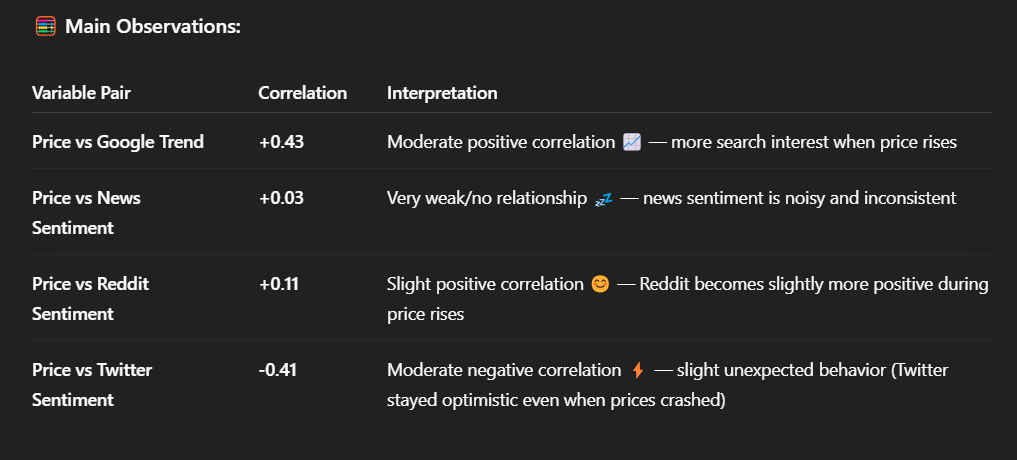

**🧠 Key Insights:**

Google Trends is the most strongly correlated with Bitcoin price (+0.43) 🚀
→ More public attention = more price activity.

Reddit sentiment shows slight positive relationship with price 🧠
→ Reddit discussions mirror some price movements but are noisy.

News sentiment is very weakly correlated 📢
→ News reacts emotionally but inconsistently to Bitcoin price movements.

Twitter sentiment shows surprising negative correlation 😮
→ Likely because Twitter remained positive even during the May crash (delayed emotional reaction).

**🎯 Conclusion:**

Google Trends appears to be the most useful early indicator among all.

Sentiment scores alone (especially from news and Twitter) cannot reliably predict price unless combined with other signals.

Combining price action, Google Trends, and sentiment shifts could improve forecasting models.

**✅ Overall:**

The heatmap reveals that public attention (Google search interest) is more closely aligned with Bitcoin’s price movements than raw sentiment scores from News, Reddit, or Twitter.



In [ ]:
# Step 1: Fill missing values for all important columns
columns_to_fix = ['price', 'google_trend', 'news_sentiment', 'reddit_sentiment', 'twitter_sentiment']

for col in columns_to_fix:
    merged_df[col] = merged_df[col].fillna(method='ffill')  # forward fill
    merged_df[col] = merged_df[col].fillna(0)  # if still missing, fill with 0 (very safe)

# Step 2: Now recalculate rolling averages properly
window_size = 7

merged_df['price_rolling'] = merged_df['price'].rolling(window=window_size).mean()
merged_df['google_trend_rolling'] = merged_df['google_trend'].rolling(window=window_size).mean()
merged_df['news_sentiment_rolling'] = merged_df['news_sentiment'].rolling(window=window_size).mean()
merged_df['reddit_sentiment_rolling'] = merged_df['reddit_sentiment'].rolling(window=window_size).mean()
merged_df['twitter_sentiment_rolling'] = merged_df['twitter_sentiment'].rolling(window=window_size).mean()


In [ ]:
# Plot 1: Bitcoin Price vs Google Trends
fig, ax1 = plt.subplots(figsize=(14,6))
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Price (USD)', color=color)
ax1.plot(merged_df.index, merged_df['price_rolling'], color=color, label='Bitcoin Price (7D Rolling Avg)')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Google Search Interest', color=color)
ax2.plot(merged_df.index, merged_df['google_trend_rolling'], color=color, linestyle='--', label='Google Trend (7D Rolling Avg)')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('📈 Bitcoin Price vs Google Trends (7-Day Rolling Average)')
fig.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# Plot 2: Bitcoin Price vs News Sentiment
fig, ax1 = plt.subplots(figsize=(14,6))
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Price (USD)', color=color)
ax1.plot(merged_df.index, merged_df['price_rolling'], color=color, label='Bitcoin Price (7D Rolling Avg)')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('News Sentiment', color=color)
ax2.plot(merged_df.index, merged_df['news_sentiment_rolling'], color=color, linestyle='--', label='News Sentiment (7D Rolling Avg)')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('📈 Bitcoin Price vs News Sentiment (7-Day Rolling Average)')
fig.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# Plot 3: Bitcoin Price vs Reddit Sentiment
fig, ax1 = plt.subplots(figsize=(14,6))
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Price (USD)', color=color)
ax1.plot(merged_df.index, merged_df['price_rolling'], color=color, label='Bitcoin Price (7D Rolling Avg)')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Reddit Sentiment', color=color)
ax2.plot(merged_df.index, merged_df['reddit_sentiment_rolling'], color=color, linestyle='--', label='Reddit Sentiment (7D Rolling Avg)')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('📈 Bitcoin Price vs Reddit Sentiment (7-Day Rolling Average)')
fig.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# Plot 4: Bitcoin Price vs Twitter Sentiment
fig, ax1 = plt.subplots(figsize=(14,6))
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Price (USD)', color=color)
ax1.plot(merged_df.index, merged_df['price_rolling'], color=color, label='Bitcoin Price (7D Rolling Avg)')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:purple'
ax2.set_ylabel('Twitter Sentiment', color=color)
ax2.plot(merged_df.index, merged_df['twitter_sentiment_rolling'], color=color, linestyle='--', label='Twitter Sentiment (7D Rolling Avg)')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('📈 Bitcoin Price vs Twitter Sentiment (7-Day Rolling Average)')
fig.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
import statsmodels.api as sm
from datetime import timedelta
import matplotlib.pyplot as plt

# 1) Re-index so we have a DatetimeIndex
btc_series = merged_df.reset_index().set_index('date')['price']

# 2) Fit ARIMA on the *entire* series (so we can get in-sample fits)
model_full = sm.tsa.ARIMA(btc_series, order=(5,1,0))
fit_full   = model_full.fit()

# 3) In-sample one-step forecasts (fitted values)
#    - start at the first date + 1 (because of differencing)
#    - end at the last historical date
pred_insample = fit_full.get_prediction(start=1, end=len(btc_series)-1, dynamic=False)
pred_mean_insample = pred_insample.predicted_mean
conf_int_insample  = pred_insample.conf_int()

# 4) Out-of-sample 30-day forecast
fc = fit_full.get_forecast(steps=30)
pred_mean_oos = fc.predicted_mean
conf_int_oos  = fc.conf_int()
last_date     = btc_series.index[-1]
oos_index     = pd.date_range(last_date + timedelta(days=1), periods=30, freq='D')

# 5) Plot everything
plt.figure(figsize=(14,6))

# actual
plt.plot(btc_series.index, btc_series, label='Actual Price', color='blue')

# in-sample fit (one-step ahead)
plt.plot(pred_mean_insample.index, pred_mean_insample,
         label='ARIMA In-Sample Prediction', color='orange')

# out-of-sample forecast
plt.plot(oos_index, pred_mean_oos,
         label='ARIMA 30-Day Forecast', color='red')

# shaded conf int: in-sample
plt.fill_between(pred_mean_insample.index,
                 conf_int_insample.iloc[:,0],
                 conf_int_insample.iloc[:,1],
                 color='orange', alpha=0.2)

# shaded conf int: out-of-sample
plt.fill_between(oos_index,
                 conf_int_oos.iloc[:,0],
                 conf_int_oos.iloc[:,1],
                 color='pink', alpha=0.2)

plt.title('📈 Bitcoin Price: Actual vs ARIMA In-Sample Fit + Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**🧩 Two Different Things on One Plot**

Orange Line & Shaded Band (“In-Sample Prediction”)

What it is: ARIMA’s one-step-ahead prediction for each day using the true prior price.

Why it matches so well: For each date, the model “cheats” by looking at the real yesterday’s price before forecasting today’s.

When you’d use it: To see how well the model can fit the history—essentially a smoothed version of the actual.

Red Line & Pink Cone (“30-Day Forecast”)

What it is: ARIMA’s out-of-sample forecast for the next 30 days after your last real data point.

Why it flattens: The model only knows the final historical price, so its best guess is “stay near here,” and the pink cone shows growing uncertainty as you go further out.

**🔄 In-Sample vs True Forecast**

In-Sample (dynamic=False):

Each forecasted point uses the actual value from the day before.

Gives you a near-perfect fit (that’s what you saw in orange).

True Out-of-Sample Forecast:

Starts at the last known price and then only uses its own previous forecasts.

That’s your red line + pink cone.



In [ ]:
from statsmodels.tsa.arima.model import ARIMA

def walk_forward_arima(series, order, test_size):
    history    = list(series[:-test_size])
    test       = series[-test_size:]
    predictions = []

    for actual in test:
        model = ARIMA(history, order=order).fit()
        yhat  = model.forecast()[0]        # forecast next step
        predictions.append(yhat)
        history.append(actual)             # then append the true test value

    return test, predictions

# 1) Extract the price array
price_array = btc_series.values

# 2) Run a 30-day walk-forward backtest
actual30, pred30 = walk_forward_arima(price_array, order=(5,1,0), test_size=30)

# 3) Build a date index for those last 30 days
test_index = btc_series.index[-30:]

# 4) Plot actual vs predicted on the same dates
plt.figure(figsize=(14,5))
plt.plot(btc_series.index, btc_series, color='blue', label='Full History')
plt.plot(test_index, pred30,      color='red',  label='ARIMA Walk-Forward Forecast')
plt.scatter(test_index, actual30,  color='black', label='Actual Test Data', s=15)
plt.axvline(test_index[0], linestyle='--', color='gray')
plt.title('🔁 ARIMA Walk-Forward Backtest (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# 1) Select and clean features
features = [
    'price',
    'google_trend_rolling',
    'news_sentiment_rolling',
    'reddit_sentiment_rolling',
    'twitter_sentiment_rolling'
]
data = merged_df[features].dropna()

# 2) Save price min/max for inverse-scaling later
price_vals   = data['price'].values.reshape(-1,1)
price_min, price_max = price_vals.min(), price_vals.max()

# 3) Scale all features to [0,1]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data.values)

# 4) Build sequences for LSTM
window = 30
X, y = [], []
for i in range(window, len(scaled)):
    X.append(scaled[i-window:i, :])    # 30 days of all features
    y.append(scaled[i, 0])             # target = scaled price column
X, y = np.array(X), np.array(y)

# 5) Train/test split (last 30 days for test)
test_size = 30
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# 6) Build the LSTM model
n_features = X_train.shape[2]
model = Sequential([
    LSTM(50, input_shape=(window, n_features)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# 7) Train
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=2
)

# 8) Forecast on test set (one-step ahead, known exog)
y_pred_scaled = model.predict(X_test).flatten()

# 9) Inverse-scale predictions and actuals
y_test_price = y_test * (price_max - price_min) + price_min
y_pred_price = y_pred_scaled * (price_max - price_min) + price_min

# 10) Compute metrics
rmse = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
mape = np.mean(np.abs((y_test_price - y_pred_price) / y_test_price)) * 100
print(f"✅ LSTM Test RMSE:  {rmse:.2f} USD")
print(f"✅ LSTM Test MAPE: {mape:.2f}%")

# 11) Build date index for test period
test_index = data.index[-test_size:]

# 12) Plot actual vs LSTM forecast
plt.figure(figsize=(14,6))
plt.plot(data.index, data['price'], label='Full History', color='blue')
plt.plot(test_index, y_pred_price,     label='LSTM Forecast', color='green')
plt.scatter(test_index, y_test_price,   label='Actual Test Data', color='black', s=20)
plt.axvline(test_index[0], linestyle='--', color='gray')
plt.title('🔮 Bitcoin Price: LSTM One-Step-Ahead Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
